In [ ]:
!pip install einops
!pip install pylcs
!pip install transformers
!pip install genomic-benchmarks
!pip install datasets
!pip install tokenizers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.5-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.5-py3-none-any.whl (240 kB)
  Created wheel for pylcs: filename=pylcs-0.1.1-cp310-cp310-linux_x86_64.whl size=1081957 sha256=5042ef68f2d18d4410e216f517f2e71866181a26b7e16c4ef6fc4fffb13d76c9
  Stored in directory: /root/.cache/pip/wheels/eb/64/e8/c902162e883f432251466566e011016795ea03b95d4350d0ee
Successfully built pylcs
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.6 MB/s eta 0:00:00
  Created wheel for genomic-benchmarks: filename=genomic_benchmarks-0.0.9-py3-none-any.whl size=22507 sha256=3fd045daa8d1ac0ae3b8f00152bd6b884934caedcead810d36e644e618065f5d
  Stored in directory: /root/.cache/pip/wheels/86/78/72/de9d75be800b6d679b8814b9663b3f610c34188b443b8b9b77
Successfully built genomic-benchmarks
   ━━━━━━━━━━

In [ ]:
import pandas as pd
from genomic_benchmarks.data_check import list_datasets
from genomic_benchmarks.data_check import info
from genomic_benchmarks.loc2seq import download_dataset
import torch
import transformers
from transformers import AutoTokenizer
import pylcs
from datasets import load_dataset, get_dataset_config_names
from tokenizers import Tokenizer, models, trainers, normalizers
import time
import concurrent.futures
import pandas as pd
import numpy as np

/usr/local/lib/python3.10/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
import google.colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
gb_datasets = list_datasets()
gue_datasets = get_dataset_config_names("leannmlindsey/GUE")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(gb_datasets)

['human_nontata_promoters', 'human_ocr_ensembl', 'drosophila_enhancers_stark', 'dummy_mouse_enhancers_ensembl', 'human_ensembl_regulatory', 'human_enhancers_cohn', 'human_enhancers_ensembl', 'demo_human_or_worm', 'demo_coding_vs_intergenomic_seqs']


In [ ]:
print(gue_datasets)

['emp_H3', 'emp_H3K14ac', 'emp_H3K36me3', 'emp_H3K4me1', 'emp_H3K4me2', 'emp_H3K4me3', 'emp_H3K79me3', 'emp_H3K9ac', 'emp_H4', 'emp_H4ac', 'human_tf_0', 'human_tf_1', 'human_tf_2', 'human_tf_3', 'human_tf_4', 'mouse_0', 'mouse_1', 'mouse_2', 'mouse_3', 'mouse_4', 'prom_300_all', 'prom_300_notata', 'prom_300_tata', 'prom_core_all', 'prom_core_notata', 'prom_core_tata', 'splice_reconstructed', 'virus_covid', 'virus_species_40', 'fungi_species_20', 'EPI_K562', 'EPI_HeLa-S3', 'EPI_NHEK', 'EPI_IMR90', 'EPI_HUVEC', 'EPI_GM12878']


In [ ]:
dataset_name = "virus_covid"
dataset = load_dataset("leannmlindsey/GUE", name=dataset_name)

split = "train"
split_dataset = dataset[split]

#print(split_dataset[0])
#print(split_dataset[0]["sequence"])

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

In [ ]:
def select_sequences(dataset):
    sequences = []
    for example in dataset:
        sequences.append(example["sequence"])
    return sequences

In [ ]:
def load_tokenizer(tokenizer_file):
  tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M")
  return tokenizer

In [ ]:
seq = select_sequences(split_dataset)

In [ ]:
tokenizer_path = '/content/drive/My Drive/VOCABULARY_OUTPUT/tokenizer_DNABERT2.json'
tokenizer = load_tokenizer(tokenizer_path)

tokenizer_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/168k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def calculate_parity(seq1,seq2):
  actual_lcs = pylcs.lcs_string_length(seq1,seq2)
  match_list = pylcs.lcs_string_idx(seq1, seq2)
  #print(match_list)
  #colored_s1, colored_s2 = pylcs.coloring_match_sequence(match_list, seq1, seq2, 11, 11, "#2266ff", "#2266ff", t=1)
  #print(colored_s1)
  #print(colored_s2)
  inputs1 = tokenizer(seq1, return_tensors = 'pt')["input_ids"]
  inputs2 = tokenizer(seq2, return_tensors = 'pt')["input_ids"]
  result = longest_common_substring(inputs1, inputs2)
  overlap =tokenizer.convert_ids_to_tokens(result)
  overlapstring = ''.join(map(str, overlap))
  #print("Parity:"+ str(len(overlapstring)/actual_lcs))
  return len(overlapstring)/actual_lcs

In [ ]:
def longest_common_substring(seq1, seq2):
    # Convert tensors to lists
    list1 = seq1.numpy().flatten().tolist()
    list2 = seq2.numpy().flatten().tolist()

    # Get lengths of the lists
    len1, len2 = len(list1), len(list2)

    # Create a 2D array to store lengths of common substrings
    dp = [[0] * (len2 + 1) for _ in range(len1 + 1)]

    # Variable to keep track of the length of the longest common substring
    longest_length = 0
    end_index_list1 = 0

    # Fill the dp array
    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            if list1[i - 1] == list2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
                if dp[i][j] > longest_length:
                    longest_length = dp[i][j]
                    end_index_list1 = i
            else:
                dp[i][j] = 0  # Reset since the substring has been broken

    # Extract the longest common substring
    start_index_list1 = end_index_list1 - longest_length
    longest_common_substr = list1[start_index_list1:end_index_list1]

    return longest_common_substr

# Example usage
#tensor1 = torch.tensor([[1, 5, 1468, 105, 19, 485, 1049, 2]])
#tensor2 = torch.tensor([[1, 1942, 32, 485, 1049, 2]])

#result = longest_common_substring(tensor1, tensor2)
#print("Longest Common Substring:", result)


In [ ]:
def extract_subsequences(seq, overlap, seg_length):
  #print(seq)
  subsequences = []
  if len(seq) < 3*seg_length:
    print("sequence is only: " + str(len(seq)))
    raise ValueError("Each sequence must be at least 3*seg_length nucleotides long")

  # Extract the four specified subsequences
  subseq1 = seq[0:seg_length]
  subseq2 = seq[seg_length-overlap:2*seg_length]
  subseq3 = seq[2*seg_length-overlap:3*seg_length]

  subsequences.append([subseq1, subseq2, subseq3])

  return subsequences

In [ ]:
seq = seq[0:5000]

In [ ]:
def dataset_parity(dataset_name,seq,overlap, seg_length):
    data = []

    for i, s in enumerate(seq):
      seq1 = s
      overlapping_seq = extract_subsequences(seq1,overlap, seg_length)
      for j in range(len(overlapping_seq[0])-1):
        parity = calculate_parity(overlapping_seq[0][j],overlapping_seq[0][j+1])
        data.append({
            "dataset": dataset_name,
            "i": i,
            "overlap_index": j,
            "parity": parity,
            "seq1": overlapping_seq[0][j],
            "seq2": overlapping_seq[0][j+1]
        })
    return data

In [ ]:
df_list = []
for dataset_name in gue_datasets:
  print(dataset_name)
  if "EPI" in dataset_name:
    break
  dataset = load_dataset("leannmlindsey/GUE", name=dataset_name)
  split = "train"
  split_dataset = dataset[split]
  seq = select_sequences(split_dataset)
  seq = seq[0:100]
  seg_length = int(len(seq[0])/4)
  overlap = int(seg_length/2)
  temp_parity = dataset_parity(dataset_name,seq,overlap,seg_length)

  # Convert to DataFrame
  temp_df = pd.DataFrame(temp_parity)

  # Add a column to identify the dataset
  temp_df['dataset_name'] = dataset_name

  # Append to the list of DataFrames
  df_list.append(temp_df)

# Concatenate all DataFrames into a single DataFrame
final_df = pd.concat(df_list, ignore_index=True)

emp_H3


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

emp_H3K14ac


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

emp_H3K36me3


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

emp_H3K4me1


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

emp_H3K4me2


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

emp_H3K4me3


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

emp_H3K79me3


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

emp_H3K9ac


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

emp_H4


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

emp_H4ac


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

human_tf_0


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

human_tf_1


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

human_tf_2


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

human_tf_3


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

human_tf_4


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

mouse_0


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

mouse_1


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

mouse_2


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

mouse_3


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

mouse_4


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

prom_300_all


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

prom_300_notata


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

prom_300_tata


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

prom_core_all


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

prom_core_notata


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

prom_core_tata


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

splice_reconstructed


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

virus_covid
virus_species_40


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

fungi_species_20


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

EPI_K562


In [ ]:
final_df

,dataset,i,overlap_index,parity,seq1,seq2,dataset_name
0,emp_H3,0,0,0.951613,CTGAAATTTTTTTCGTTTCGCCACCAAGAAAGGCTAATTGAATACA...,AGCTAAGTGGGCATGAAGGTTATGAATTGTAATTGGAGGTGCGGCA...,emp_H3
1,emp_H3,0,1,0.935484,AGCTAAGTGGGCATGAAGGTTATGAATTGTAATTGGAGGTGCGGCA...,AAACCTCAAGAGGTTCGCAAAGCCAACATCATCGCTGCACGTTCTG...,emp_H3
2,emp_H3,1,0,1.000000,ATATGCTCGAAAATGTAGCTATATTTCACGGATGAATAACTCGTAA...,TGGACCTAGGAACGATCAAGTCAACGTTGTATTTTGGTTCGGCAAA...,emp_H3
3,emp_H3,1,1,0.870968,TGGACCTAGGAACGATCAAGTCAACGTTGTATTTTGGTTCGGCAAA...,AGAATAAGAGGATACTTTCAAGAGAAGTTCAAAAAAGAATCATTAT...,emp_H3
4,emp_H3,2,0,0.903226,CAACGGTACCCAATGGTTCCATCTCTAAGTCGTTAGGGCCAATCGT...,CACCTTCATCTTCGCTGTCTTCCTCACTCAACTTGAAAGTGGAAGA...,emp_H3
...,...,...,...,...,...,...,...
5995,fungi_species_20,97,1,0.992000,GACGGTAACTCCAAGTCAAATGGCCCGTTTCTCTCAATCGGGTGAC...,TAACTGTAGATTAGGCCAACAAGATGCCCCTAACTATCTCCCAGGT...,fungi_species_20
5996,fungi_species_20,98,0,0.992000,GGGAAGATCAGCGTAATTGATGCCTTTTGTTTTGGCACTAACATTT...,TGTACCGACTGGACTACTAGACAAAGTTGACAAGTACGCATTGTTA...,fungi_species_20
5997,fungi_species_20,98,1,0.999200,TGTACCGACTGGACTACTAGACAAAGTTGACAAGTACGCATTGTTA...,GTCTCCAATTGAAGTGGGTTCGGAAACAATACAAACTCCAGAGACA...,fungi_species_20
5998,fungi_species_20,99,0,0.993600,ACTGTGTCACCGCCACCGTCATTACCATCATTTGTCCATAGGCCGG...,AAAGAAAAGAAGGAAAAGAAGGAAAAGAAGGAAAACAAGGAAAAGA...,fungi_species_20


In [ ]:
final_df['dataset'].unique()

array(['emp_H3', 'emp_H3K14ac', 'emp_H3K36me3', 'emp_H3K4me1',
       'emp_H3K4me2', 'emp_H3K4me3', 'emp_H3K79me3', 'emp_H3K9ac',
       'emp_H4', 'emp_H4ac', 'human_tf_0', 'human_tf_1', 'human_tf_2',
       'human_tf_3', 'human_tf_4', 'mouse_0', 'mouse_1', 'mouse_2',
       'mouse_3', 'mouse_4', 'prom_300_all', 'prom_300_notata',
       'prom_300_tata', 'prom_core_all', 'prom_core_notata',
       'prom_core_tata', 'splice_reconstructed', 'virus_covid',
       'virus_species_40', 'fungi_species_20'], dtype=object)

In [ ]:
order_dict = {'emp_H3':60, 'emp_H3K14ac':61, 'emp_H3K36me3':62, 'emp_H3K4me1':63,
       'emp_H3K4me2':64, 'emp_H3K4me3':65, 'emp_H3K79me3':66, 'emp_H3K9ac':67,
       'emp_H4':68, 'emp_H4ac':69, 'human_tf_0':50, 'human_tf_1':51, 'human_tf_2':52,
       'human_tf_3':53, 'human_tf_4':54, 'mouse_0':55, 'mouse_1':56, 'mouse_2':57,
       'mouse_3':58, 'mouse_4':59, 'prom_300_all': 20, 'prom_300_notata':21,
       'prom_300_tata':22, 'prom_core_all':25, 'prom_core_notata':26,
       'prom_core_tata':27, 'splice_reconstructed':10, 'virus_covid':70,
       'virus_species_40':0, 'fungi_species_20':0}
final_df['order'] = final_df['dataset'].map(order_dict)

In [ ]:
category_dict = {'emp_H3':'EMP', 'emp_H3K14ac':'EMP', 'emp_H3K36me3':'EMP', 'emp_H3K4me1':'EMP',
       'emp_H3K4me2':'EMP', 'emp_H3K4me3':'EMP', 'emp_H3K79me3':'EMP', 'emp_H3K9ac':'EMP',
       'emp_H4':'EMP', 'emp_H4ac':'EMP', 'human_tf_0':'TF', 'human_tf_1':'TF', 'human_tf_2':'TF',
       'human_tf_3':'TF', 'human_tf_4':'TF', 'mouse_0':'TF', 'mouse_1':'TF', 'mouse_2':'TF',
       'mouse_3':'TF', 'mouse_4':'TF', 'prom_300_all':'Promoters', 'prom_300_notata':'Promoters',
       'prom_300_tata':'Promoters', 'prom_core_all':'Promoters', 'prom_core_notata':'Promoters',
       'prom_core_tata':'Promoters', 'splice_reconstructed':'SS', 'virus_covid':'Virus',
       'virus_species_40':'Virus', 'fungi_species_20':'Virus'}
final_df['category'] = final_df['dataset'].map(category_dict)

In [ ]:
final_df = final_df[final_df['dataset'] != 'fungi_species_20']
final_df = final_df[final_df['dataset'] != 'virus_species_40']
final_df = final_df.sort_values(by='order')

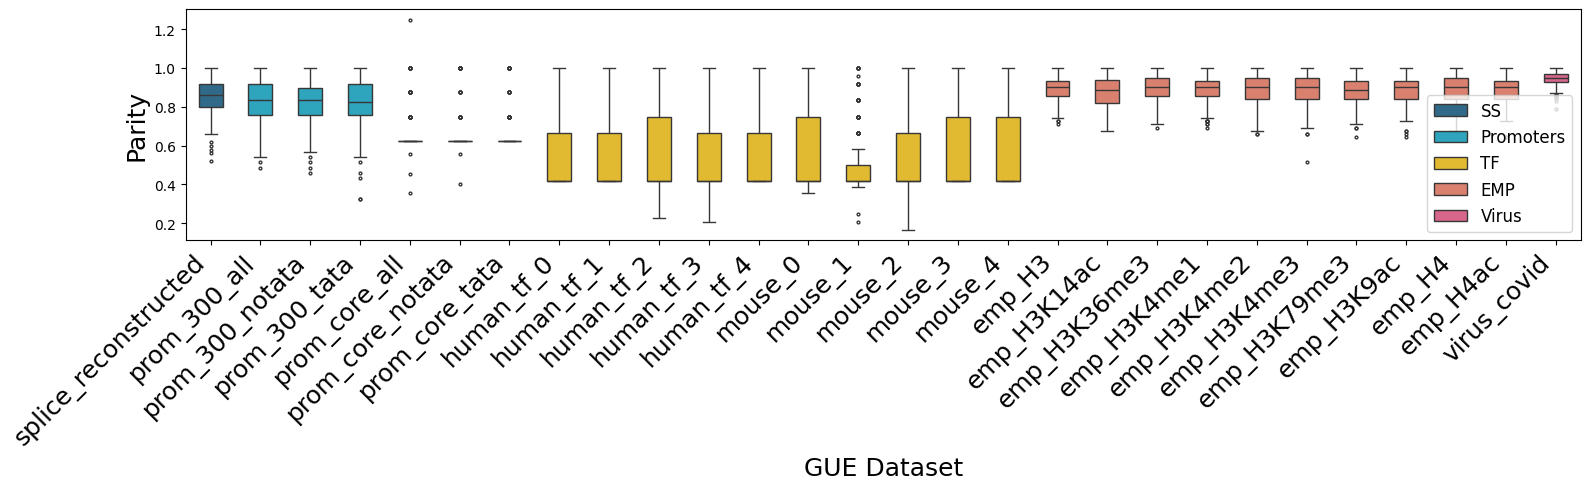

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the box plot
plt.figure(figsize=(18, 3))
cc = ['#226f97', '#16b3d5', '#feca15', '#eb755c', '#e95484']
sns.boxplot(x='dataset', y='parity', hue='category', palette=cc, data=final_df, width=0.6, fliersize=2, gap=.2)

#plt.title('Parity by Dataset using DNABERT-2 Tokenizer')
plt.ylabel('Parity', fontsize=18)
plt.xlabel('GUE Dataset', fontsize=18)
plt.xticks(rotation=45,ha='right',fontsize=18)
plt.legend(fontsize=12)

plt.savefig('box_plot_comparison_parity.pdf', format='pdf',bbox_inches='tight')
plt.show()

In [ ]:
final_df[final_df['dataset'] == 'virus_covid']

,dataset,i,overlap_index,parity,seq1,seq2,dataset_name,order,category
5534,virus_covid,67,0,0.935484,TACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTT...,TAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCA...,virus_covid,70,Virus
5526,virus_covid,63,0,0.959677,ATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGT...,TAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGC...,virus_covid,70,Virus
5527,virus_covid,63,1,0.959677,TAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGC...,CGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGT...,virus_covid,70,Virus
5528,virus_covid,64,0,0.862903,TTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAA...,TTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGT...,virus_covid,70,Virus
5529,virus_covid,64,1,0.975806,TTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGT...,TTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGT...,virus_covid,70,Virus
...,...,...,...,...,...,...,...,...,...
5469,virus_covid,34,1,0.943548,TGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGT...,GAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTC...,virus_covid,70,Virus
5470,virus_covid,35,0,0.975806,CTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACAGACTGGTTT...,TAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATT...,virus_covid,70,Virus
5471,virus_covid,35,1,0.967742,TAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATT...,CATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGT...,virus_covid,70,Virus
5461,virus_covid,30,1,0.854839,CTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATA...,GTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAAT...,virus_covid,70,Virus


In [ ]:
example_58 = final_df.iloc[5401]
example_58

,5526
dataset,virus_covid
i,63
overlap_index,0
parity,0.959677
seq1,ATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGT...
seq2,TAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGC...
dataset_name,virus_covid
order,70
category,Virus


In [ ]:
seq1=example_58['seq1']
seq2=example_58['seq2']

In [ ]:
actual_lcs = pylcs.lcs_string_length(seq1,seq2)
match_list = pylcs.lcs_string_idx(seq1, seq2)
colored_s1, colored_s2 = pylcs.coloring_match_sequence(match_list, seq1, seq2, 11, 11, "#2266ff", "#2266ff", t=1)
print(colored_s1)
print(colored_s2)
inputs1 = tokenizer(seq1, return_tensors = 'pt')["input_ids"]
inputs2 = tokenizer(seq2, return_tensors = 'pt')["input_ids"]
#print(inputs1)
#print(inputs2)
tokens1 = tokenizer.convert_ids_to_tokens(inputs1[0])
p_tokens1 = ' '.join(map(str, tokens1))
tokens2 = tokenizer.convert_ids_to_tokens(inputs2[0])
p_tokens2 = ' '.join(map(str, tokens2))
#print(p_tokens1)
#print(p_tokens2)
result = longest_common_substring(inputs1, inputs2)
overlap =tokenizer.convert_ids_to_tokens(result)
overlapstring = ' '.join(map(str, overlap))
#print(result)
#print(overlapstring)

match_list = pylcs.lcs_string_idx(p_tokens1, p_tokens2)
colored_s1, colored_s2 = pylcs.coloring_match_sequence(match_list, p_tokens1, p_tokens2, 11, 11, "#2266ff", "#2266ff", t=1)
print(colored_s1)
print(colored_s2)


ATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAA
TAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCA
[CLS] A TATG GTGATT GCCTT GGTGA TATT GCTG CTAGAGA CCTCATT TGTG CACAAAA GTTTAA CGG CCTTA CTGTTTT GCCA CCTTTG CTCACAGA TGAAA TGATT GCTCAA TACA CTTCTG CACTG TTA GCGG GTACAA TCACTT CTG GTTGGA CCTTTG GTGCAGG TGCTG CATTA CAAA TACCA TTTG CTATG CAAATG GCTTA TAGGTT TAATG GTATT GGAGTTA CACAGAA TGTT CTC TATGA GAA [SEP]
[CLS] TA GCGG GTACAA TCACTT CTG GTTGGA CCTTTG GTGCAGG TGCTG CATTA 

In [ ]:
length=len(example_58['seq1'])
final_df['length'] = final_df['seq1'].apply(lambda x: len(x))

In [ ]:
final_df['length']

,length
5251,150
5272,100
5271,150
5270,100
5269,150
...,...
5469,373
5470,249
5471,373
5461,373


In [ ]:
correlation = final_df[['length', 'parity']].corr().iloc[0, 1]
correlation

0.6444807031819948

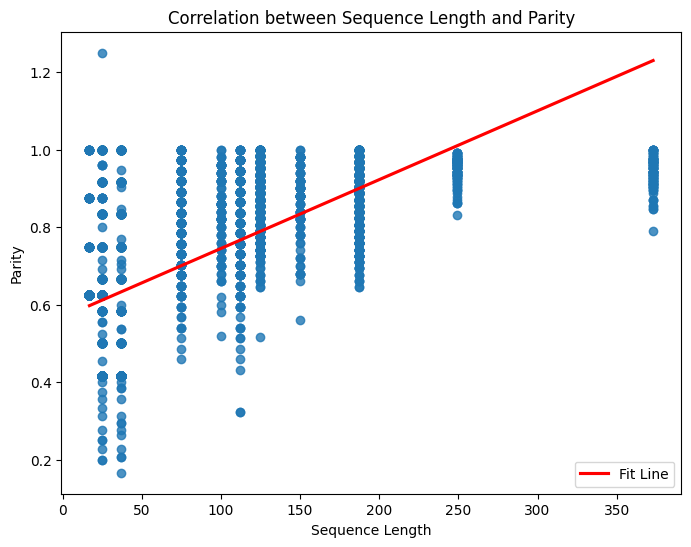

In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(x='length', y='parity', data=final_df, ci=None, line_kws={'color': 'red', 'label': 'Fit Line'})
plt.title('Correlation between Sequence Length and Parity')
plt.xlabel('Sequence Length')
plt.ylabel('Parity')
plt.legend()
plt.show()

Updated correlation between 'Sequence Length' and 'Parity': 0.6444807031819948


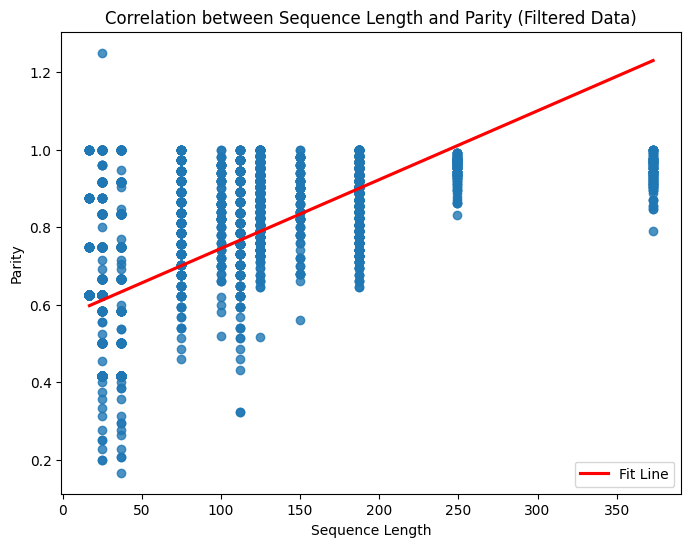

In [ ]:
# Filter out rows where 'seq1_length' > 999
filtered_df = final_df[final_df['length'] <= 999]

# Recompute the correlation between 'seq1_length' and 'parity'
correlation = filtered_df[['length', 'parity']].corr().iloc[0, 1]

print(f"Updated correlation between 'Sequence Length' and 'Parity': {correlation}")

# Create a scatter plot with a regression line for the filtered data
plt.figure(figsize=(8, 6))
sns.regplot(x='length', y='parity', data=filtered_df, ci=None, line_kws={'color': 'red', 'label': 'Fit Line'})
plt.title('Correlation between Sequence Length and Parity (Filtered Data)')
plt.xlabel('Sequence Length')
plt.ylabel('Parity')
plt.legend()
plt.show()

In [ ]:
import scipy.stats as stats
import seaborn as sns
parity_length_corr, parity_length_p = stats.pearsonr(final_df['length'], final_df['parity'])
print(f"Correlation between parity and sequence length: {parity_length_corr}, p-value: {parity_length_p}")

Correlation between parity and sequence length: 0.6444807031819935, p-value: 0.0


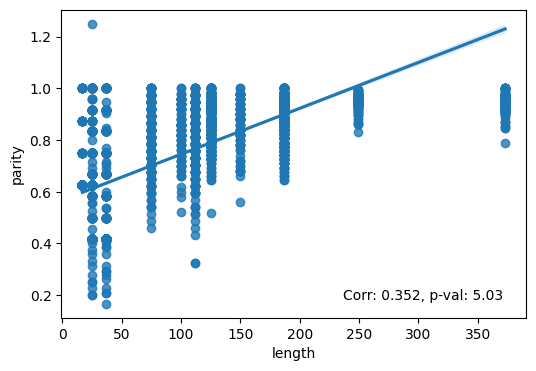

In [ ]:
plt.figure(figsize=(6, 4))
sns.regplot(x='length', y='parity', data=filtered_df)
plt.annotate('Corr: 0.352, p-val: 5.03', xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom')
plt.savefig('parity_correlation.pdf', format='pdf')

In [ ]:
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression

# Assuming final_df is your DataFrame

# Pearson Correlation
pearson_corr = final_df[['length', 'parity']].corr().iloc[0, 1]
print(f"Pearson correlation: {pearson_corr}")

# Spearman's Rank Correlation
spearman_corr, _ = spearmanr(final_df['length'], final_df['parity'])
print(f"Spearman's rank correlation: {spearman_corr}")

# Prepare data for R² and Mutual Information
X = final_df[['length']].values.reshape(-1, 1)  # Independent variable
y = final_df['parity'].values  # Dependent variable

# Coefficient of Determination (R²)
model = LinearRegression()
model.fit(X, y)
r_squared = model.score(X, y)
print(f"Coefficient of Determination (R²): {r_squared}")

# Mutual Information
mi = mutual_info_regression(X, y)
print(f"Mutual Information: {mi[0]}")


Pearson correlation: 0.6444807031819948
Spearman's rank correlation: 0.6492134594338091
Coefficient of Determination (R²): 0.41535537677395695
Mutual Information: 1.1438237179454767


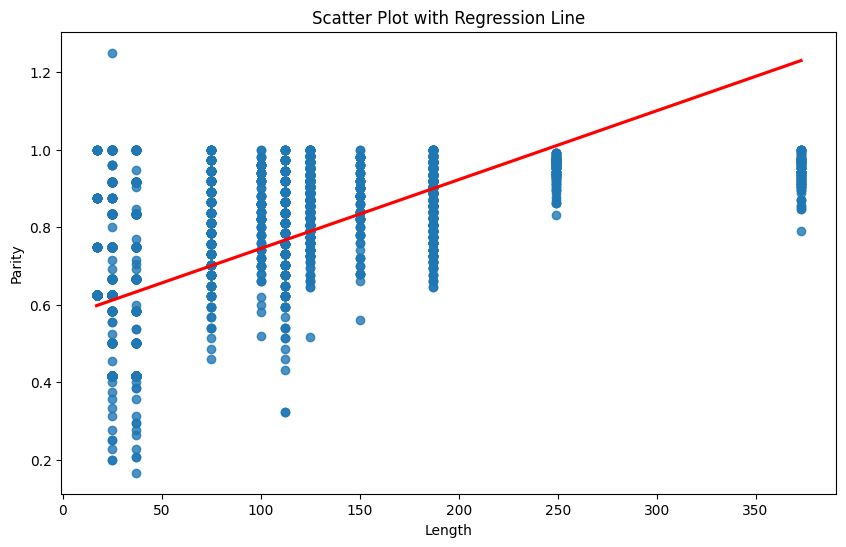

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='length', y='parity', data=final_df, ci=None, line_kws={"color": "red"})
plt.title("Scatter Plot with Regression Line")
plt.xlabel("Length")
plt.ylabel("Parity")
plt.show()

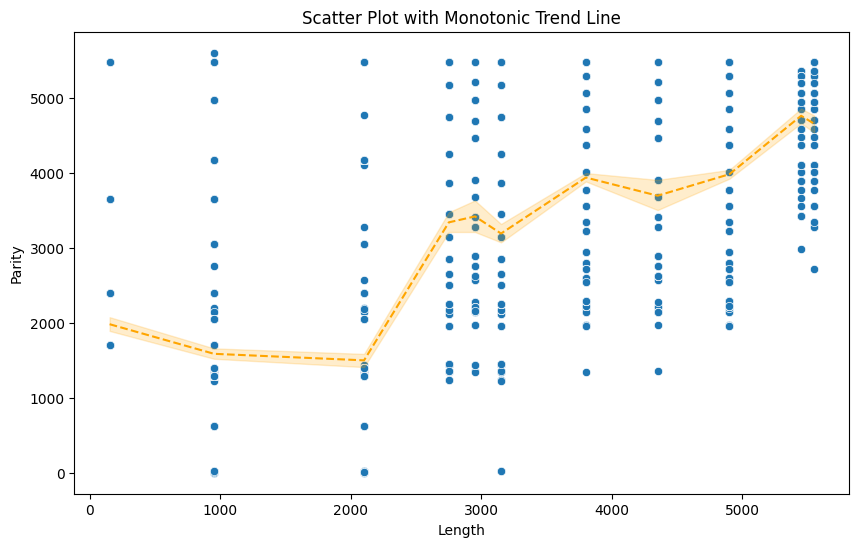

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_df['length'].rank().astype(float), y=final_df['parity'].rank().astype(float))
sns.lineplot(x=final_df['length'].rank().astype(float), y=final_df['parity'].rank().astype(float), color='orange', linestyle='--')
plt.title("Scatter Plot with Monotonic Trend Line")
plt.xlabel("Length")
plt.ylabel("Parity")
plt.show()